In [0]:
from numpy import load
from numpy import zeros
from numpy import ones
import numpy as np
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
import glob
import cv2

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# define the discriminator model
def define_discriminator(image_shape):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # source image input
  in_src_image = Input(shape=image_shape)
  # target image input
  in_target_image = Input(shape=image_shape)
  # concatenate images channel-wise
  merged = Concatenate()([in_src_image, in_target_image])
  # C6
  d = Conv2D(64, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  # C128
  d = Conv2D(128, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C256
  d = Conv2D(256, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C512
  d = Conv2D(512, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(512, (2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(1, (2,2), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  # define model
  model = Model([in_src_image, in_target_image], patch_out)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model

In [0]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
  

In [0]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  init = RandomNormal(stddev=0.02)
  g = Conv2DTranspose(n_filters, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  g = BatchNormalization()(g, training=True)
  if dropout:
    g = Dropout(0.5)(g, training=True)
  g = Concatenate()([g, skip_in])
  g = Activation('relu')(g)
  return g

In [0]:
def define_generator(image_shape):
  init = RandomNormal(stddev = 0.02)
  print("here")
  in_image = Input(shape=image_shape)
  e1 = define_encoder_block(in_image, 62, batchnorm=False)
  print("here")
  e2 = define_encoder_block(e1, 128)
  print("here2")
  e3 = define_encoder_block(e2, 256)
  print("here2")
  e4 = define_encoder_block(e3, 512)
  print("here3")
  #e5 = define_encoder_block(e4, 512)
  #e6 = define_encoder_block(e5, 512)
  #e7 = define_encoder_block(e6, 512)
  #print(e7.shape)
  print("here3")
  b = Conv2D(512, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(e4)
  print(b.shape)
  print("here4")
  b = Activation('relu')(b)
  #print(b.shape)
  #d1 = decoder_block(b, e7, 512)
  print("here5")
  #d2 = decoder_block(d1, e6, 512)
  
  #d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(b, e4, 512, dropout=False)
  print("here6")
  d5 = decoder_block(d4, e3, 256, dropout=False)
  print("here7")
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  g = Conv2DTranspose(3, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)
  model = Model(in_image, out_image)
  print("here4")
  return model

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [0]:
# load and prepare training images
def load_real_samples():
  X1 = []
  X2 = []
  train_x_list=glob.glob("drive/My Drive/satimages/nopath/*.png")[3:]
  test_x_list = glob.glob("drive/My Drive/satimages/path/*.png")[3:]
  train_images = []
  test_images = []
  for i in range(len(train_x_list)):
    train_images.append(cv2.imread(train_x_list[i])[0:64,0:64])
    test_images.append(cv2.imread(test_x_list[i])[0:64,0:64])
  X1 = np.array(train_images)
  X2 = np.array(test_images)
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return[X1,X2]

In [0]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y


In [0]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [0]:
# generate samples and save as a plot and save the model
k = ''
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	k = filename2
	print('>Saved: %s and %s' % (filename1, filename2))

In [0]:
def train(d_model, g_model, gan_model, dataset, n_epochs=200, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [0]:
dataset = load_real_samples()
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
print(image_shape)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (325, 64, 64, 3) (325, 64, 64, 3)
(64, 64, 3)













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
here
here
here2
here2
here3
here3
(?, 2, 2, 512)
here4
here5
here6
here7
here4


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




>1, d1[0.289] d2[0.485] g[49.541]
>2, d1[0.268] d2[0.465] g[69.177]
>3, d1[0.314] d2[0.502] g[37.886]
>4, d1[0.345] d2[0.441] g[30.282]
>5, d1[0.265] d2[0.491] g[43.462]
>6, d1[0.339] d2[0.454] g[54.315]
>7, d1[0.323] d2[0.417] g[48.466]
>8, d1[0.359] d2[0.437] g[49.635]
>9, d1[0.346] d2[0.446] g[49.880]
>10, d1[0.312] d2[0.351] g[46.172]
>11, d1[0.365] d2[0.407] g[36.475]
>12, d1[0.309] d2[0.424] g[35.777]
>13, d1[0.314] d2[0.441] g[34.386]
>14, d1[0.324] d2[0.362] g[37.114]
>15, d1[0.348] d2[0.496] g[62.857]
>16, d1[0.372] d2[0.386] g[36.029]
>17, d1[0.412] d2[0.384] g[27.391]
>18, d1[0.305] d2[0.407] g[35.452]
>19, d1[0.367] d2[0.409] g[33.228]
>20, d1[0.418] d2[0.431] g[38.807]
>21, d1[0.360] d2[0.367] g[41.411]
>22, d1[0.339] d2[0.416] g[37.851]
>23, d1[0.351] d2[0.404] g[29.815]
>24, d1[0.421] d2[0.438] g[38.486]
>25, d1[0.365] d2[0.382] g[29.542]
>26, d1[0.452] d2[0.354] g[34.226]
>27, d1[0.308] d2[0.371] g[35.696]
>28, d1[0.388] d2[0.381] g[28.966]
>29, d1[0.460] d2[0.344] g[

In [0]:
X1 = []
X2 = []
train_x_list=glob.glob("drive/My Drive/satimages/nopath/*.png")[0:10]
test_x_list = glob.glob("drive/My Drive/satimages/path/*.png")[0:10]
train_images = []
test_images = []
for i in range(len(train_x_list)):
  train_images.append(cv2.imread(train_x_list[i])[0:64,0:64])
  test_images.append(cv2.imread(test_x_list[i])[0:64,0:64])
X1 = np.array(train_images)
X2 = np.array(test_images)
t1 = (X1 - 127.5) / 127.5
t2 = (X2 - 127.5) / 127.5

In [0]:
from keras.models import load_model
model_test = load_model('model_065000.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
images = model_test.predict(t1)
images = (images + 1) / 2.0
print(images.shape)


(10, 64, 64, 3)


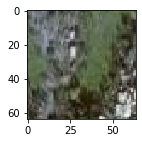

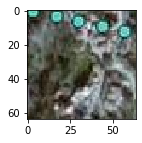

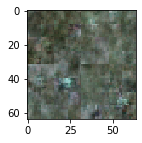

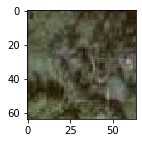

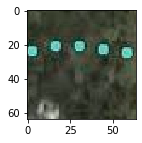

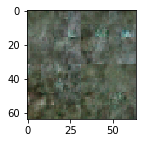

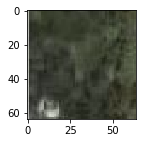

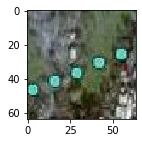

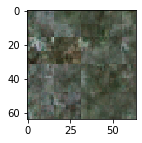

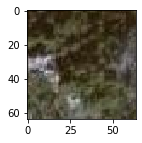

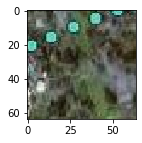

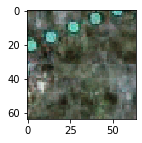

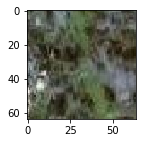

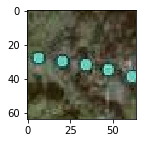

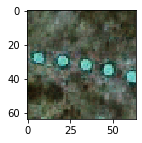

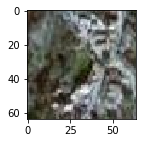

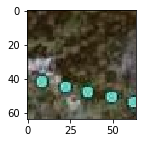

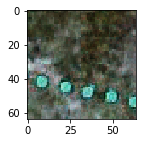

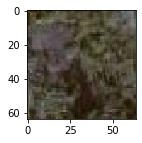

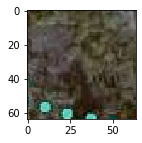

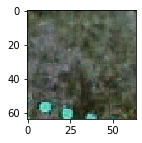

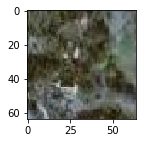

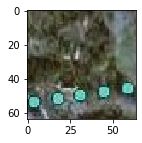

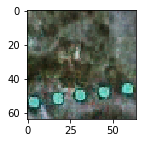

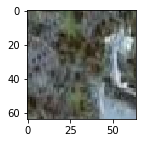

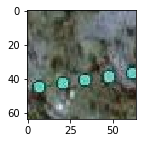

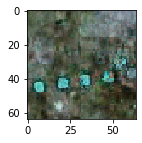

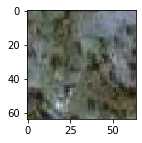

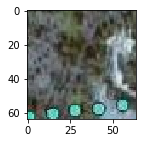

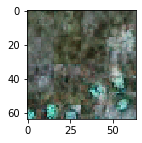

In [0]:
import matplotlib.pyplot as plt
for k in range(10):
  decoded = np.asarray(X1[k])
  data = decoded.reshape(64,64,3)
  plt.figure(figsize=(2,2))
  plt.imshow(data)
  plt.savefig("input"+str(k)+".png")
  plt.show()
  
  decoded = np.asarray(X2[k])
  data = decoded.reshape(64,64,3)
  plt.figure(figsize=(2,2))
  plt.imshow(data)
  plt.savefig("expected"+str(k)+".png")
  plt.show()
  
  decoded = np.asarray(images[k])
  data = decoded.reshape(64,64,3)
  plt.figure(figsize=(2,2))
  plt.imshow(data)
  plt.savefig("output"+str(k)+".png")
  plt.show()
  